In [5]:
import sktime
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

## Стратегии прогнозирования

## Рекурсивная стратегия

Давайте представим, что нам необходимо спрогнозировать какой-то временной ряд на 5 шагов вперёд. Точку, из которой мы строим прогноз, обычно называют forecast origin, а то, на сколько шагов мы прогнозируем -- горизонт прогнозирования (forecast horizon). Пусть также у нас предполагается самая простая модель:

$$ y_t = \beta_0 + \beta_1 y_{t-1}+ \epsilon_t$$

Как только мы найдём любым доступным способом $\hat{\beta}_0 $ и $\hat{\beta}_1$, то сможем построить прогноз на один шаг вперёд:

$$ \hat{y}_{t+1} = \hat{\beta}_0 + \hat{\beta}_1 y_{t}$$

На один шаг мы построили. Теперь давайте подумаем про второй. Хотелось бы, конечно, построить следующее уравнение:

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 y_{t+1}$$

Однако $y_{t+1}$ мы не знаем. Однако знаем оценку, $\hat{y}_{t+1}$. Ну значит давайте и подставим её, чтобы всё работало. Таким образом прогноз на два шага будет основываться на прогнозе на один шаг:

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+1}$$

Эту стратегию использую чаще всего. Более того, большая часть статистических моделей, которые мы будем проходить впоследствии, просто технически не могут реализовать какую-то другую. Однако она не лишена недостатков. Один из основных -- накопление ошибки при рекурсивных прогнозах. С каждым шагом ошибка предыдущего шага порождает ещё большу ошибку на последующих. Особенно сильно такой эффект наблюдается, когда модель имеет авторегрессию большего порядка. Значит, что в каждом последующем прогнозе будет учитываться оценка не только предыдущего момента времени, но и оценки всех значений, входящих в уравнение. Например:

$$ \hat{y}_{t+3} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+2} + \hat{\beta}_2 \hat{y}_{t+1} + \hat{\beta}_2 y_{t}$$

Помимо этого существует ещё одна существенная проблема. Давайте снова представим простую модель, но уже с экзогенной переменной $x_t$:

$$ y_t = \beta_0 + \beta_1 y_{t-1} + \gamma_1 x_{t-1} \epsilon_t$$

$$ \hat{y}_{t+1} = \hat{\beta}_0 + \hat{\beta}_1 y_{t} + + \hat{\gamma}_1 x_{t} $$

При одношаговом прогнозе в целом никаких проблем не возникает. Однако на втором шаге уже проблемы: 

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+1} + \hat{\gamma}_1 x_{t+1} $$

$x_{t+1}$ нам взять неоткуда. Следовательно, у нас два варианта. Либо прогнозировать отдельно ряд $x_t$, что добавит ещё больше шума в модель, либо не использовать этот регрессор вообще и полагаться только на фичи, которые либо основаны на $y_t$ (тоже добавит шума), либо могут быть сгенерированы независимо (например, календарные фичи). На самом деле часто бывают задачи, в которых экзогенных переменных нет вовсе и такая проблема не стоит, но всё же это достаточно редкий случай. 

Наши данные из-за большого количества экзогенных и производных переменных не подойдут под рекурсивную стратегию, поэтому приведём здесь пример на более игрушечных данных.

## Прямая стратегия

Внимательный слушатель резонно задастся вопросом: А зачем, собственно, предсказывать все горизонты одной моделью. И правда, да ничего не мешает. Пусть нам нужно прогнозировать на h шагов. Тогда оценим h моделей вида:

$$ \hat{y}_{t+1} = \hat{\beta}_0^1 + \hat{\beta}_1^1 y_{t}$$

$$ \hat{y}_{t+2} = \hat{\beta}_0^2 + \hat{\beta}_1^2 y_{t}$$

$$ \hat{y}_{t+3} = \hat{\beta}_0^3 + \hat{\beta}_1^3 y_{t}$$

$$ \cdots $$

$$ \hat{y}_{t+k} = \hat{\beta}_0^k + \hat{\beta}_1^k y_{t}$$

Недостатки такого подхода:
* Вместо одной модели нужно оценивать h. Это очень сильно увеличивает вычислительные затраты, особенно при кросс-валидации.
* Растёт общий разброс модели, так как оцениваем в h раз больше параметров.

Преимущества такого подхода:
* Очевидно, меньше смещение. Ошибки предыдущих горизонтов не влияют на проноз по текущему.
* Более явная модель для многошагового прогноза. Можно, например, подобрать одни переменные, важные для прогноза на длинный период и друге для короткого. 
* Обычно высокий разброс не так критичен как смещение рекурсивной стратегии и в моей практике я стараюсь использовать прямую стратегию.
* Никаких проблем с экзогенными и производными переменными.
* Часто очень неплохо работает вкупе с обычной линейной регрессией и при грамотно сгенерированных фичах

# Различные модели sktime

In [2]:
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

## Превращение моделей sklearn в модели для временных рядов

0.12715938596932008

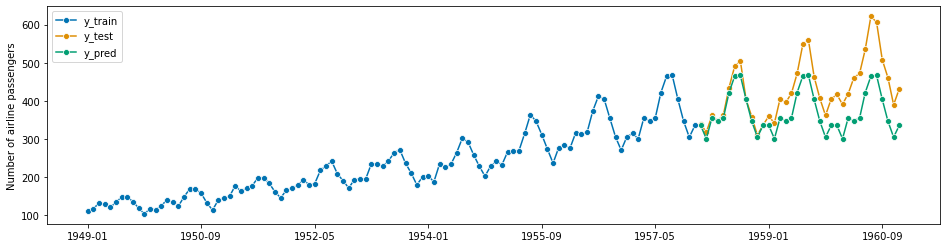

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.14234936455030817

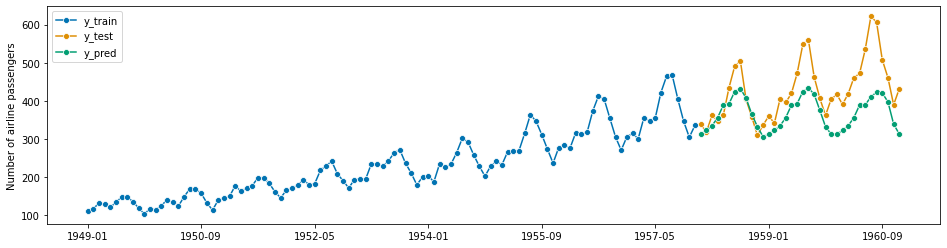

In [4]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5)
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.13349496929062954

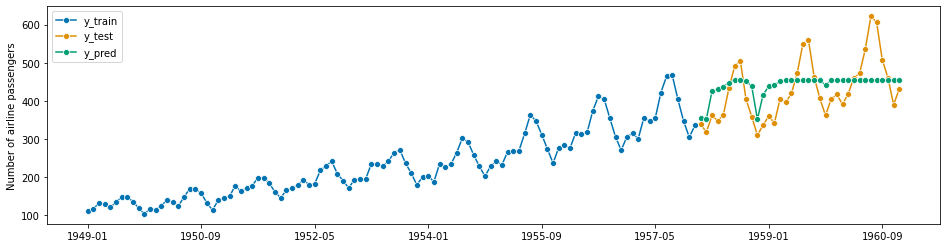

In [5]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.0969749024503959

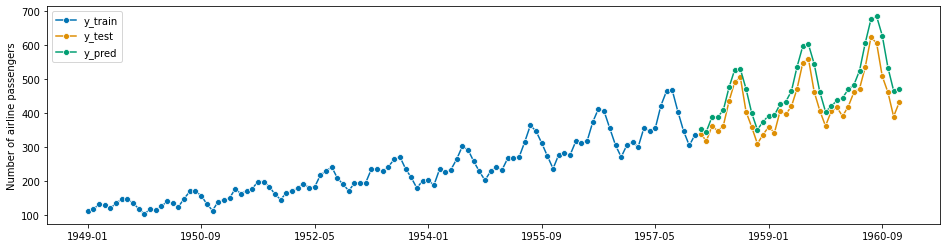

In [6]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

0.06374523640538235

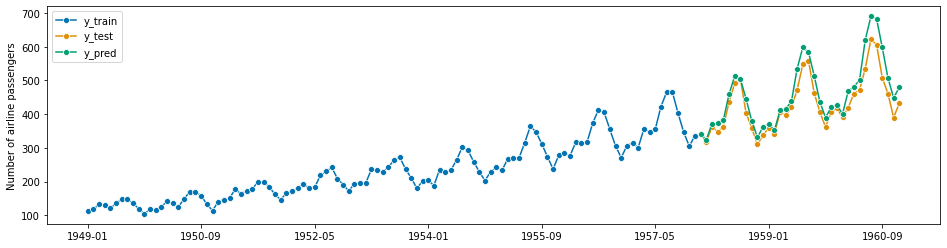

In [7]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=12, strategy="direct")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

# Модели для предсказаний в sktime

In [6]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True)

,name,estimator
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
5,BATS,<class 'sktime.forecasting.bats.BATS'>
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
9,Croston,<class 'sktime.forecasting.croston.Croston'>


In [9]:
all_estimators(
    "forecaster", as_dataframe=True, filter_tags={"scitype:y": ["univariate"]}
)

,name,estimator
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
5,BATS,<class 'sktime.forecasting.bats.BATS'>
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
7,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
8,Croston,<class 'sktime.forecasting.croston.Croston'>
9,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...


In [10]:
#TBATS
#Prophet
#ARIMA

0.043567449223420686

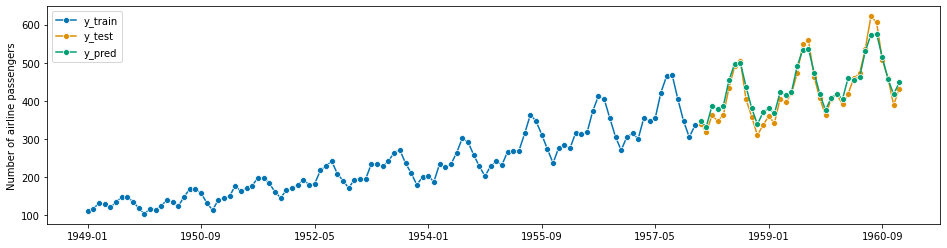

In [11]:
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [7]:
df = pd.read_csv('../data/traffic.csv', parse_dates=['report_dt'])
y_traffic = df[df.cross==1].resample('D', on='report_dt').sum()['traffic']
y_traffic_train, y_traffic_test = temporal_train_test_split(y_traffic, test_size=60)

0.056564399323650226

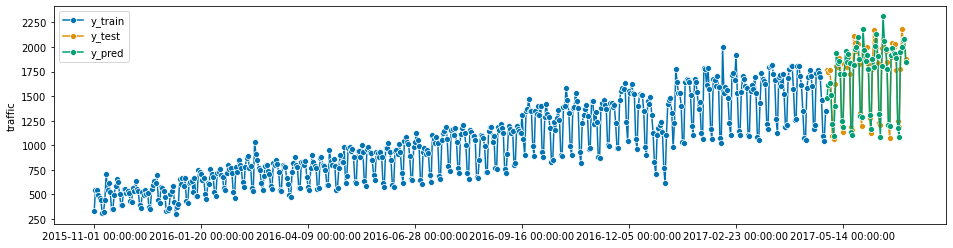

In [25]:
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA(
    order=(2, 1, 0), seasonal_order=(0, 1, 0, 7), suppress_warnings=True
)

forecaster.fit(y_traffic)
y_pred = forecaster.predict(y_traffic_test.index)
plot_series(y_traffic_train, y_traffic_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_traffic_test, y_pred, symmetric=False)

0.05124609277078672

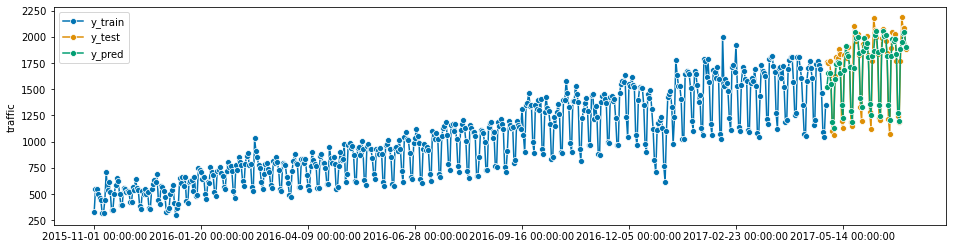

In [26]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=7, suppress_warnings=True)

forecaster.fit(y_traffic)
y_pred = forecaster.predict(y_traffic_test.index)
plot_series(y_traffic_train, y_traffic_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_traffic_test, y_pred, symmetric=False)

In [30]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  608
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -3555.751
Date:                             Tue, 21 Feb 2023   AIC                           7127.501
Time:                                     16:22:18   BIC                           7162.770
Sample:                                 11-01-2015   HQIC                          7141.223
                                      - 06-30-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0819      0.426     -0.192      0.847      -0.917       0.753
ar.L1         -0.4391      0.032    -13.813      0.000      -0.501      -0.377
ar.L2         -0.3005      0.043     -6.981      0.000      -0.385      -0.216
ar.L3         -0.1656      0.043     -3.863      0.000      -0.250      -0.082
ar.L4         -0.1496      0.045     -3.352      0.001      -0.237      -0.062
ar.S.L7        0.9969      0.003    353.168      0.000       0.991       1.002
ma.S.L7       -0.8015      0.027    -29.315      0.000      -0.855      -0.748
sigma2      7023.9090    287.963     24.392      0.000    6459.512    7588.306
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               224.67
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
AutoARIMA(sp=7, suppress_warnings=True)

# BATS и TBATS

TBATS is acronym for:

- Trigonometric seasonality
- Box-Cox transformation
- ARMA errors
- Trend
- Seasonal components

0.04530833459322449

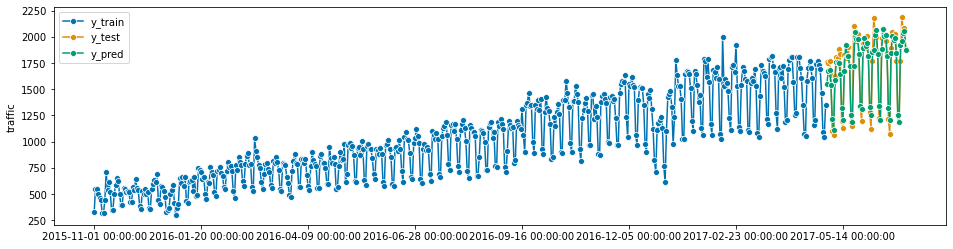

In [32]:
from sktime.forecasting.bats import BATS

forecaster = BATS(sp=7, use_trend=True, use_box_cox=False)

forecaster.fit(y_traffic)
y_pred = forecaster.predict(y_traffic_test.index)
plot_series(y_traffic_train, y_traffic_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_traffic_test, y_pred, symmetric=False)

0.04884602539987203

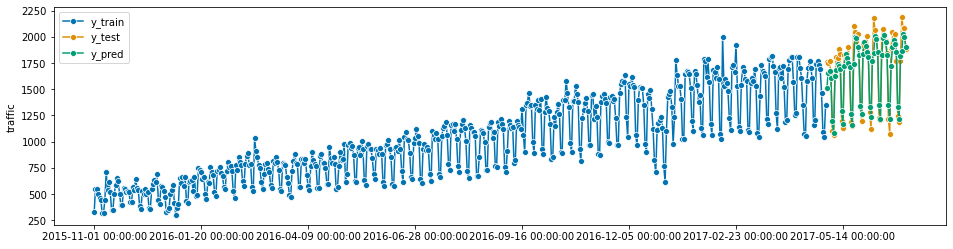

In [34]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=7, use_trend=True, use_box_cox=True)

forecaster.fit(y_traffic)
y_pred = forecaster.predict(y_traffic_test.index)
plot_series(y_traffic_train, y_traffic_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_traffic_test, y_pred, symmetric=False)

# Facebook Prophet

In [9]:
# Поговорим позже

## Пайплайны и тд

0.057276313425796525

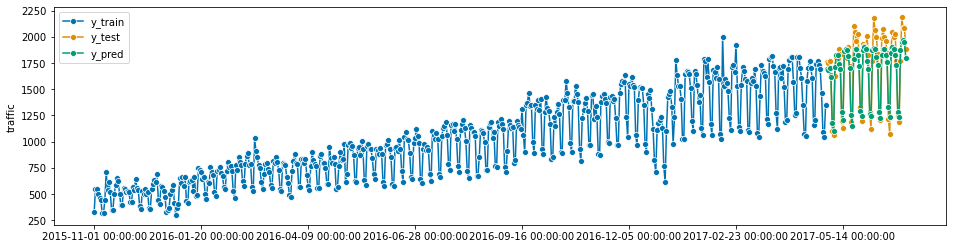

In [23]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=7)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
        (
            "forecast",
            make_reduction(
                KNeighborsRegressor(),
                window_length=30,
                strategy="recursive",
            ),
        ),
    ]
)

forecaster.fit(y_traffic_train)
y_pred = forecaster.predict(y_traffic_test.index)
plot_series(y_traffic_train, y_traffic_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_traffic_test, y_pred, symmetric=False)

Примеры использвания различных вещей,реализованных в sktime: https://github.com/sktime/sktime/tree/main/examples

Документация,которая сейчас работает: https://www.sktime.net/en/latest/api_reference.html